/tmp/ipykernel_9616/312726698.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  attn_map = torch.load(path)  # 假设这是一个 torch.Tensor


Reshaped attention map: torch.Size([16, 30, 30, 16, 30, 30])
attention_3d shape: torch.Size([16, 30, 30])


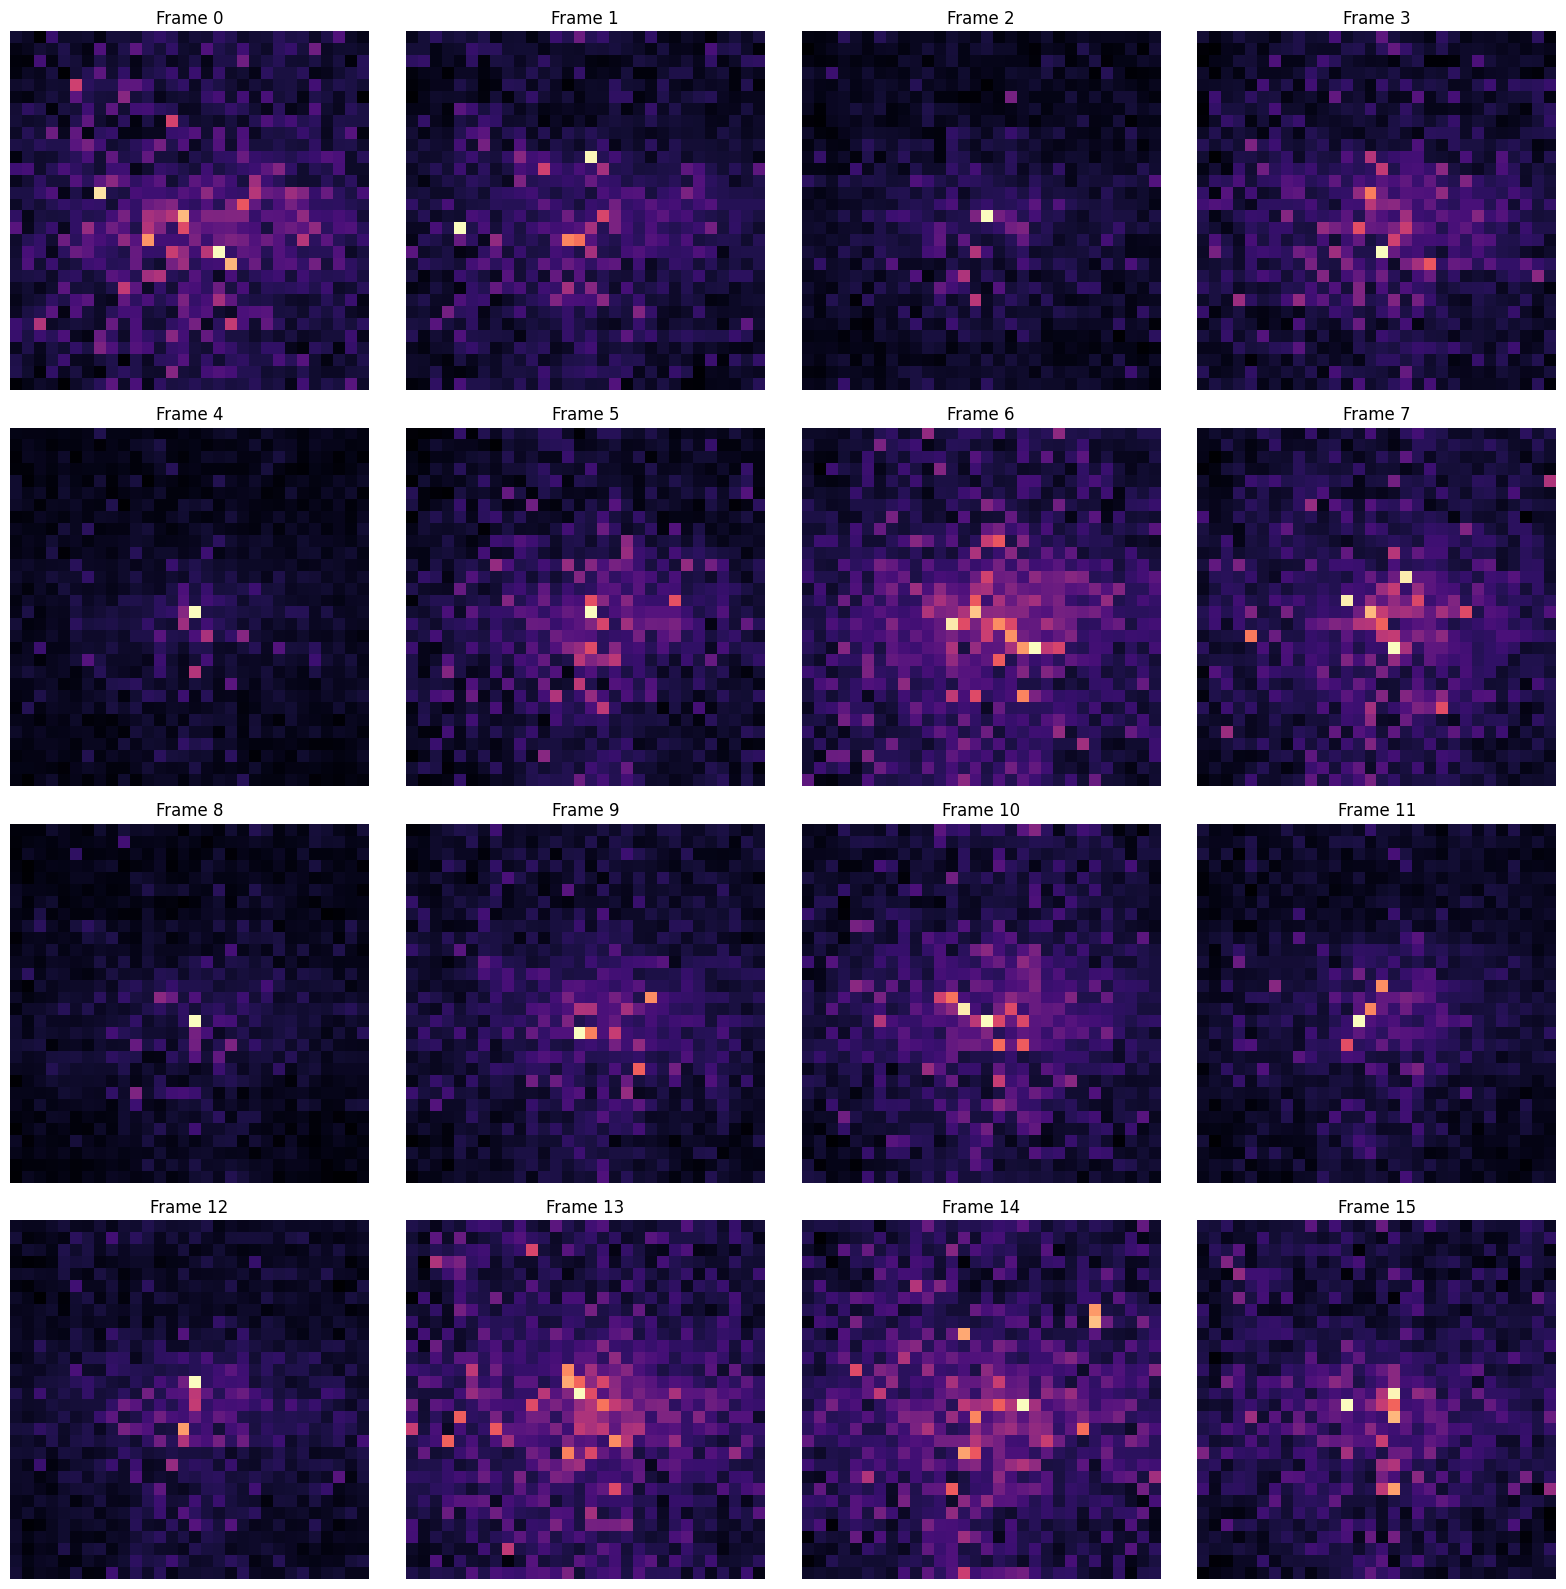

In [3]:
# In[1]:

import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

# Jupyter 内联绘图
%matplotlib inline

############################################################
#                超参数区域，可随时修改
############################################################
ATTN_MAP_PATH = "logs/attn_map_step1_layer59.pt"  # 注意力图文件 (pt)
NUM_FRAMES = 16
HEIGHT = 30
WIDTH = 30
TOKEN_IDX = 8*900 + 15*30 + 15   # 示例：t=8, h=15, w=15
############################################################

def load_and_reshape_attn_map(path, num_frames=16, height=30, width=30):
    """
    1. 从指定路径加载注意力图 (可能是1D或2D)；
    2. reshape 至 (14400,14400)；
    3. 再 reshape 至 (16,30,30,16,30,30) 便于后续操作。
    """
    attn_map = torch.load(path)  # 假设这是一个 torch.Tensor
    expected_size = num_frames * height * width  # 16*30*30 = 14400
    
    attn_map = attn_map[:expected_size, :expected_size]  # => (14400, 14400)
    # reshape 至 (t, h, w, t, h, w)
    attn_map_6d = attn_map.reshape(num_frames, height, width, 
                                   num_frames, height, width)
    return attn_map_6d

def get_cross_attn_map(attn_map_6d: torch.Tensor, token_idx, 
                       num_frames=16, height=30, width=30):
    """
    从 (t, h, w, t, h, w) 拿取单个 token 或多个 token 的聚合注意力图 => (t, h, w)
    """
    if isinstance(token_idx, list):
        mask = torch.zeros_like(attn_map_6d[0])  # => (t, h, w)
        for idx in token_idx:
            f_idx = idx // (height * width)
            hh = (idx % (height * width)) // width
            ww = idx % width
            mask += attn_map_6d[f_idx, hh, ww]
        mask /= len(token_idx)
    else:
        f_idx = token_idx // (height * width)
        hh = (token_idx % (height * width)) // width
        ww = token_idx % width
        mask = attn_map_6d[f_idx, hh, ww]
    return mask

def apply_magma_colormap(attn_2d: np.ndarray) -> np.ndarray:
    """
    将 2D attention map 转换为 magma colormap 的 RGB 图 (H x W x 3).
    """
    attn_2d = attn_2d - attn_2d.min()
    denom = (attn_2d.max() - attn_2d.min() + 1e-8)
    attn_2d = attn_2d / denom
    
    # 使用 matplotlib 的 magma colormap (返回 RGBA)
    colored = plt.cm.magma(attn_2d)
    colored_rgb = (colored[..., :3] * 255).astype(np.uint8)
    return colored_rgb

# =============== 加载并得到 (t, h, w, t, h, w) 交叉注意力映射 ===============
if not os.path.exists(ATTN_MAP_PATH):
    raise FileNotFoundError(f"未找到注意力图文件: {ATTN_MAP_PATH}")

attn_map_6d = load_and_reshape_attn_map(ATTN_MAP_PATH, NUM_FRAMES, HEIGHT, WIDTH)
print("Reshaped attention map:", attn_map_6d.shape)

# =============== 获取固定 token_idx => (t, h, w) ===============
attn_3d = get_cross_attn_map(attn_map_6d, TOKEN_IDX, NUM_FRAMES, HEIGHT, WIDTH)
print("attention_3d shape:", attn_3d.shape)

# =============== 展示热力图 (逐帧) ===============
num_frames = attn_3d.shape[0]
rows = 4
cols = num_frames // rows
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
axes = axes.flatten()  # flatten for easy indexing

for i in range(num_frames):
    attn_2d = attn_3d[i].cpu().numpy()
    color_map = apply_magma_colormap(attn_2d)
    axes[i].imshow(color_map)
    axes[i].axis('off')
    axes[i].set_title(f"Frame {i}")

plt.tight_layout()
plt.show()

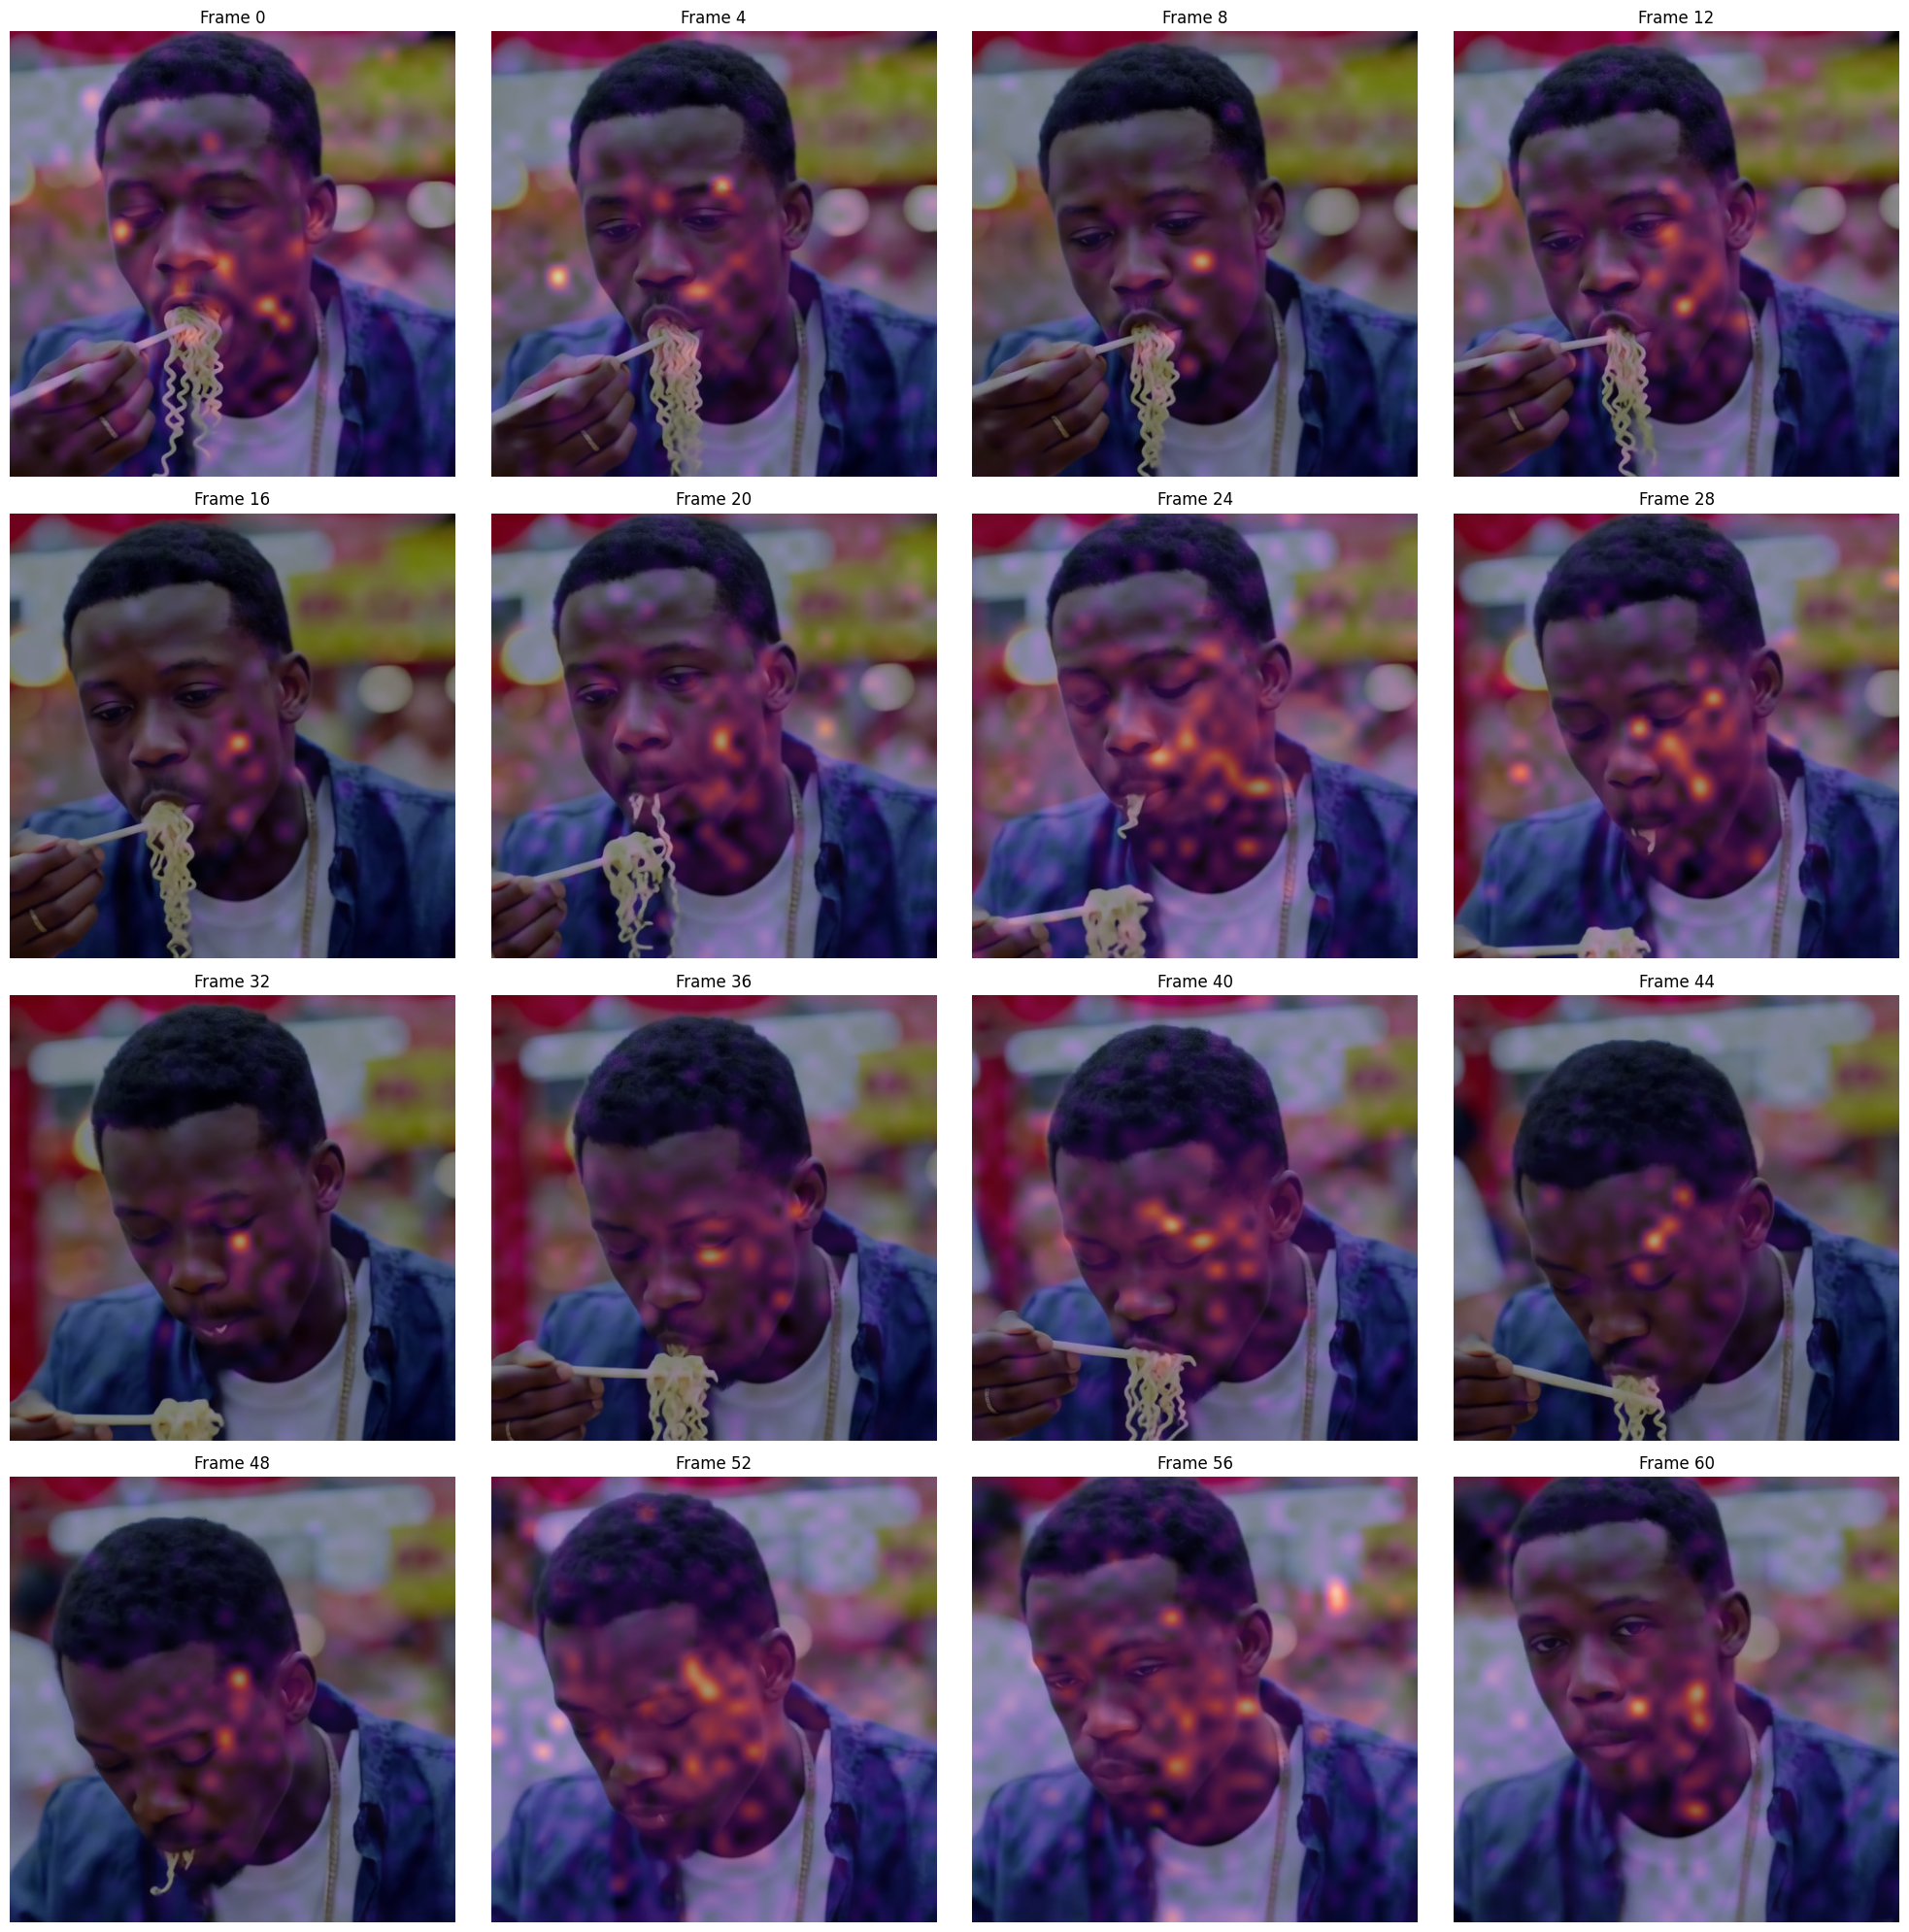

In [4]:
VIDEO_PATH = "outputs_video/hunyuan/sw/Will Smith casually eats noodles, his relaxed demeanor contrasting with the energetic background of .mp4"
NUM_FRAMES_TO_READ = 16
ALPHA = 0.5
HEIGHT, WIDTH = 480, 480
ATTN_T, ATTN_H, ATTN_W = 16, 30, 30
FRAME_INTERVAL = 4  # Add frame interval parameter

if not os.path.exists(VIDEO_PATH):
    raise FileNotFoundError(f"视频文件不存在: {VIDEO_PATH}")

cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    raise IOError(f"无法打开视频: {VIDEO_PATH}")

frames = []
frame_count = 0

while True:
    ret, frame_bgr = cap.read()
    if not ret:
        break
        
    if frame_count % FRAME_INTERVAL == 0:
        frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
        frame_rgb = cv2.resize(frame_rgb, (WIDTH, HEIGHT), interpolation=cv2.INTER_CUBIC)
        frames.append(frame_rgb)
        
        if len(frames) >= NUM_FRAMES_TO_READ:
            break
            
    frame_count += 1

cap.release()

if len(frames) == 0:
    raise ValueError("未能成功读取任何视频帧。")
elif len(frames) < NUM_FRAMES_TO_READ:
    print(f"警告：只读取到 {len(frames)} 帧，少于预期的 {NUM_FRAMES_TO_READ} 帧")

# Rest of the visualization code remains the same
num_frames = len(frames)
rows, cols = 4, 4

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
axes = axes.flatten()

for i in range(rows * cols):
    if i < num_frames:
        frame_rgb = frames[i].copy()
        attn_2d = attn_3d[i].cpu().numpy()
        attn_2d_resized = cv2.resize(attn_2d, (WIDTH, HEIGHT), interpolation=cv2.INTER_CUBIC)
        heatmap_rgb = apply_magma_colormap(attn_2d_resized)
        blended = cv2.addWeighted(frame_rgb, 1 - ALPHA, heatmap_rgb, ALPHA, 0)
        
        axes[i].imshow(blended)
        axes[i].set_title(f"Frame {i*FRAME_INTERVAL}")  # Updated frame index in title
    else:
        axes[i].imshow(np.zeros((HEIGHT, WIDTH, 3), dtype=np.uint8))
        axes[i].set_title("Empty")

    axes[i].axis('off')

plt.tight_layout()
plt.show()